In [147]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
import time
import wave
import IPython.display as ipd
import librosa.display
import sklearn
from scipy.stats import kurtosis, skew

class Audio:
    def __init__(self):
        super(Audio, self).__init__()
        
        self.SHORT_NORMALIZE = (1.0/32768.0)
        self.RATE = 44100  
        self.INPUT_BLOCK_TIME = 0.05
        self.CHUNK = int(self.RATE*self.INPUT_BLOCK_TIME)
        self.CHANNEL = 2
        
        self.microphone_name = "3- Andrea PureAudio"

    def initiate_mic(self):
        self.pa = pyaudio.PyAudio()
        device_index = self.discover_mic()  
        self.mic = pa.open(format = pyaudio.paInt16,
                    channels = self.CHANNEL,
                    rate =  self.RATE ,
                    input = True,
                    input_device_index = device_index,
                    frames_per_buffer = self.CHUNK
                    )
        
    def discover_mic(self):

        for i in range(self.pa.get_device_count() ):     
            devinfo = self.pa.get_device_info_by_index(i)   

            if self.microphone_name in devinfo["name"]:
                    device_index = i
                    return device_index

    def record_audio(self, filename, runtime):

        blocks = []

        print("Recording starts..")
        st = time.time()
        while True:
            block = self.mic.read(self.CHUNK)
            blocks.append(block)

            t = time.time() - st

            if t>runtime:        
                self.save_audio(filename, blocks)        
                self.close_mic()
                break

        print("Recording done! Saved as ", filename)

    def save_audio(self, filename, blocks):
        wf = wave.open(filename, 'wb')
        wf.setnchannels(self.CHANNEL)
        wf.setsampwidth(self.pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.RATE)
        wf.writeframes(b''.join(blocks))
        wf.close()

    def close_mic(self):
        self.mic.stop_stream()
        self.mic.close()
        self.pa.terminate()
        
class Visualize():
    def __init__(self):
        super(Visualize, self).__init__()
        
    def load_file(self, filename):
        self.x, self.sr = librosa.load(filename)
        
    def show_wave(self):
        librosa.display.waveshow(self.x, sr = self.sr)
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude (scaled)")
        plt.title("Raw signal")
    
    def show_spec(self):
        X = librosa.stft(self.x)
        Xdb = librosa.amplitude_to_db(abs(X))
        librosa.display.specshow(Xdb, sr=self.sr, x_axis='time', y_axis='hz') 
        plt.colorbar()
        plt.xlabel("Time (seconds)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Spectogram")
        
    def show_spectral_centroid(self):
        #spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
        spectral_centroids = librosa.feature.spectral_centroid(y=self.x, sr=self.sr)[0]
        spectral_centroids.shape
        # Computing the time variable for visualization
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        # Normalising the spectral centroid for visualisation
        def normalize(x, axis=0):
            return sklearn.preprocessing.minmax_scale(x, axis=axis)
        #Plotting the Spectral Centroid along the waveform
        librosa.display.waveshow(self.x, sr=self.sr, alpha=0.4)
        plt.plot(t, normalize(spectral_centroids), color='r')
        plt.title("Spectral Centroid")
             
    def show_spectral_rolloff(self): 
        spectral_centroids = librosa.feature.spectral_centroid(y=self.x, sr=self.sr)[0]
        spectral_centroids.shape
        # Computing the time variable for visualization
        frames = range(len(spectral_centroids))
        t = librosa.frames_to_time(frames)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=self.x, sr=self.sr)[0]
        librosa.display.waveshow(self.x, sr=self.sr, alpha=0.4)
        
        plt.plot(t, normalize(spectral_rolloff), color='r')
        plt.title("Spectral Rolloff")
        
    def show_mfcc(self):
        #MFCC — Mel-Frequency Cepstral Coefficients
        mfccs = librosa.feature.mfcc(y=self.x, sr=self.sr)
        librosa.display.specshow(mfccs, sr=self.sr, x_axis='time')
        
        plt.xlabel("Time (seconds)")
        plt.ylabel("Index")
        plt.title("MFCC")
    
    def show_rms_energy(self):
        # Get RMS value from each frame's magnitude value
        S, phase = librosa.magphase(librosa.stft(self.x))
        rms = librosa.feature.rms(S=S)
        times = librosa.times_like(rms)

        plt.semilogy(times, rms[0], label='RMS Energy' )
        plt.legend()
        
        plt.title("RMS Energy")
    
    def show_chroma(self):
        hop_length = 512
        chromagram = librosa.feature.chroma_stft(y=self.x, sr=self.sr, hop_length=hop_length)
        img = librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
        plt.colorbar(img)
        
        plt.title("Chroma")
        
    def show_tempogram(self):
        hop_length = 510
        # Compute local onset autocorrelation
        oenv = librosa.onset.onset_strength(y=self.x, sr=self.sr, hop_length=hop_length)
        times = librosa.times_like(oenv, sr=self.sr, hop_length=hop_length)
        tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=self.sr,
                                              hop_length=hop_length)

        librosa.display.specshow(tempogram, sr=self.sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo', cmap='magma') 
    
        # Estimate the global tempo for display purposes
        tempo = librosa.beat.tempo(onset_envelope=oenv, sr=self.sr,
                                   hop_length=hop_length)[0]

        plt.axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
        
        plt.legend(loc='upper right')
        plt.title("Tempogram")

## Record audio

In [25]:
filename = "test.wav"
runtime = 5 #sec

audio = Audio()
audio.initiate_mic()
audio.record_audio(filename, runtime)
ipd.Audio(filename)

Recording starts..
Recording done! Saved as %s test.wav


## Visualize audio

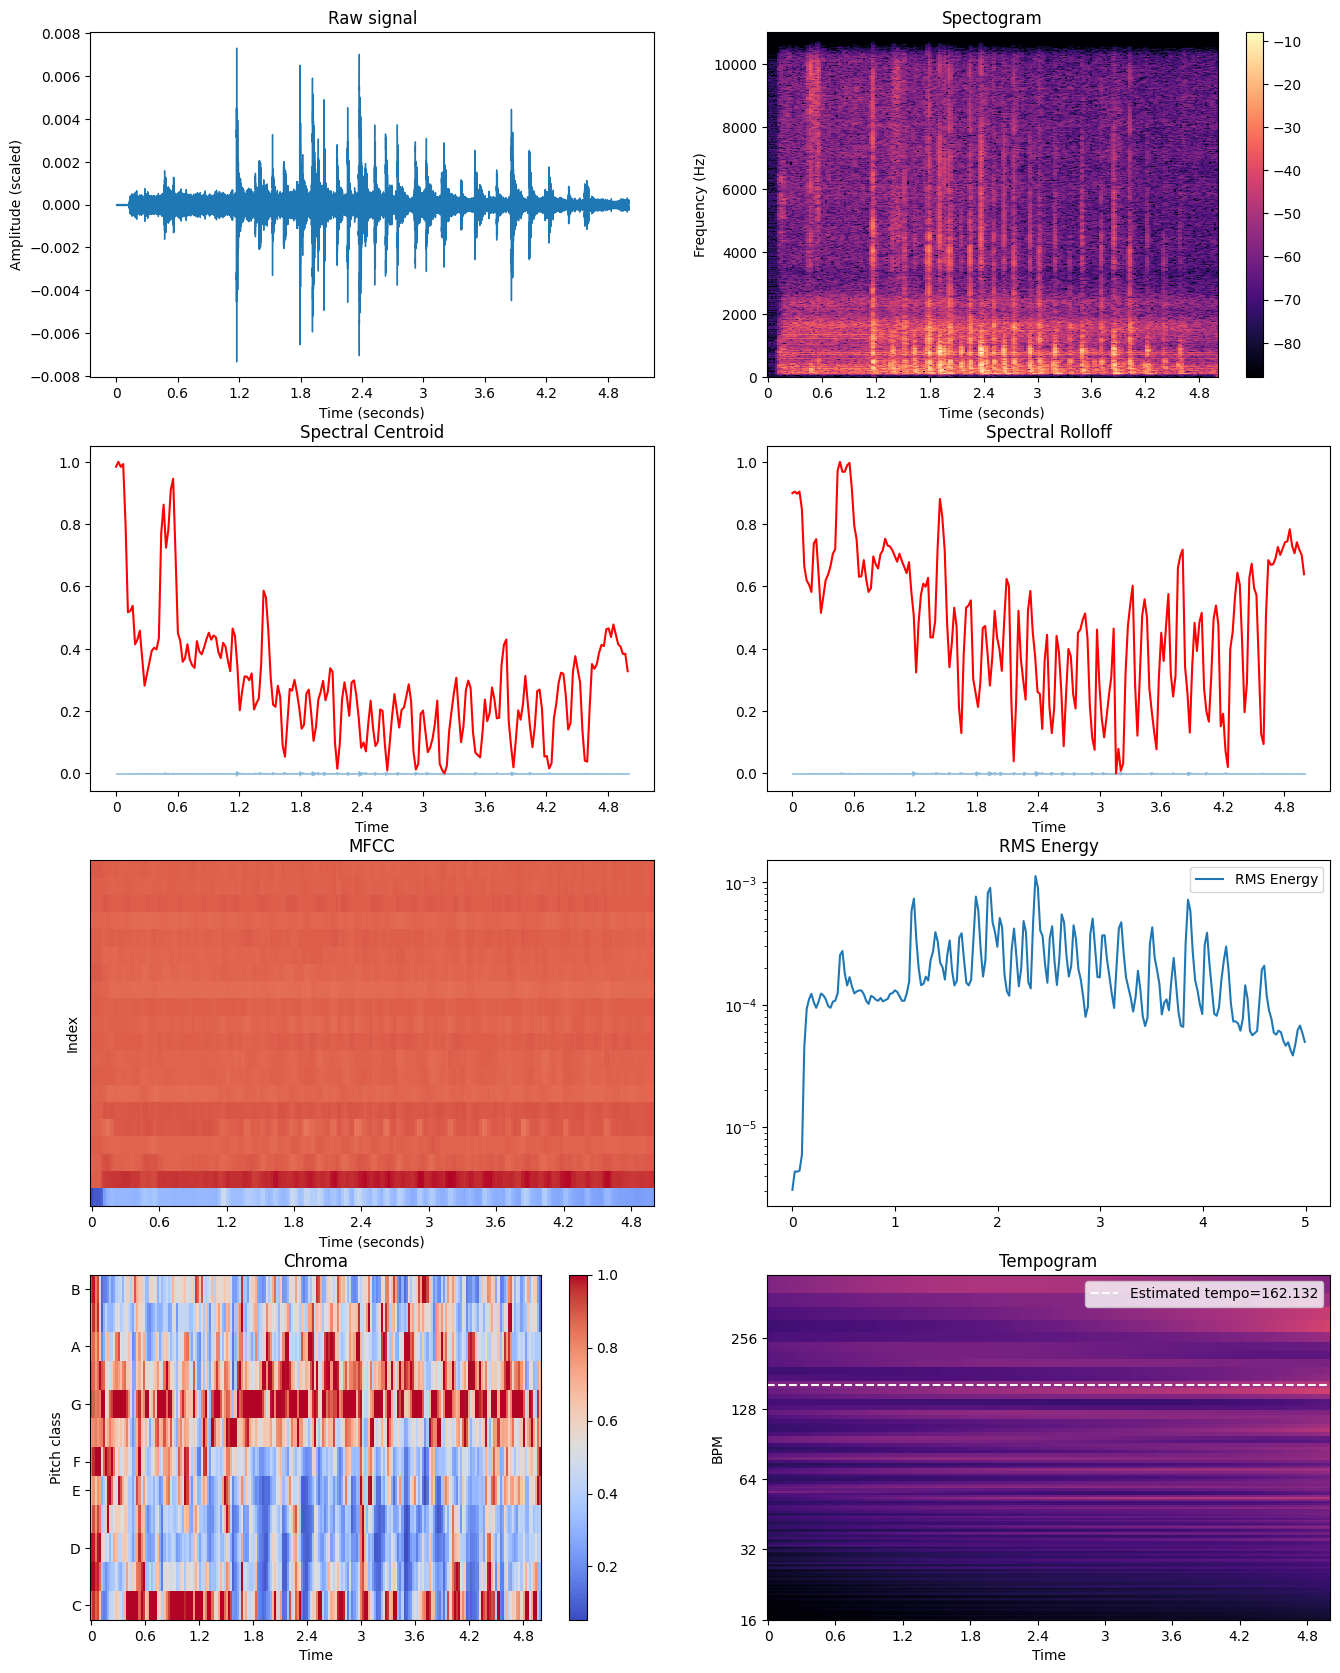

In [132]:
plt.figure(figsize=(16, 26)) 
    
visual = Visualize()

filename = "test.wav"
visual.load_file(filename)

plt.subplot(5,2,1)
visual.show_wave()

plt.subplot(5,2,2)
visual.show_spec()

plt.subplot(5,2,3)
visual.show_spectral_centroid()

plt.subplot(5,2,4)
visual.show_spectral_rolloff()

plt.subplot(5,2,5)
visual.show_mfcc()

plt.subplot(5,2,6)
visual.show_rms_energy()

plt.subplot(5,2,7)
visual.show_chroma()

plt.subplot(5,2,8)
visual.show_tempogram()

In [149]:
filename = "test.wav"
x, sr = librosa.load(filename)

std = np.std(x)
max = np.max(x)
min = np.min(x)
mean = np.mean(x)
var = np.var(x)
sk = skew(x)
kurt = kurtosis(x)
zx = sum(librosa.zero_crossings(x, pad=False))
quantiles = np.quantile(x, [0.10, 0.25, 0.50, 0.75])

print("Standard Daviation: ", std)
print("Max amplitude:", max)
print("Min amplitude: ", min)
print("Mean: ", mean)
print("Variance: ", var)
print("Skew: ", sk)
print("Kurtosis: ", kurt)
print("Zero crossings: ", zx)
print("Quantiles (10%):", quantiles[0])
print("Quantiles (25%):", quantiles[0])
print("Quantiles (50%):", quantiles[0])
print("Quantiles (75%):", quantiles[0])

TypeError: 'float' object is not callable